As robots deployments become more common, they will become yet another dancer in the sidewalk ballet. Within urban mapping, transit mobility and walkability scores have emerged as a way to measure the quality of a city's infrastructure for a specific medium of traffic. However, there is no such metric for robots! Here, we aim to envision what a 'robotability' score might look like, and how it might be used to inform urban planning and policy. 

We utilize the following data features in computing a *robotability score*: 
- Sidewalk width 
- Sidewalk quality proxied by 311 complaints 
- Pedestrian density, computed via aggregated dashcam data
- Sidewalk material (concrete, asphalt, cobblestone, etc.) 
- Connectivity: cellular coverage, WiFi availbility, IoT network coverage, and GPS coverage 
- Elevation change from beginning to end of road segment 
- Solar radiation levels, for potential solar charging and for potential overheating. 
- Proximity to hypothetical charging stations 
- Grating on sidewalk (ie in NYC, the subway grates) that might be problematic for robots to navigate 
- Snow buildup 
- Local attitudes towards robots 
- Average illegal parking levels, ie cars parked on sidewalks 
- Shade / shadows 
- Overhead covering (scaffolding, awnings, etc., in the case of non-waterproof bots)
- Zoning. My hypothesis: robots are more acceptable in commercial-zoned areas, and less acceptable in majority-residential zoned areas. 

### Other Things to Lock In (4/25/24): 
- Study period. Some of this data (311 complaints, pedestrian densities, etc., should be constrained within a time range. **Limitation: we don't have new, free dashcam data presently**)



In [1]:
# class RobotabilityGraph that inherits from Graph class 
import os
import sys 
sys.path.append("/share/ju/urban-fingerprinting")

import osmnx as ox 
import geopandas as gpd 
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
# enable latex plotting 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from glob import glob 
from tqdm import tqdm 

from shapely import wkt, LineString 

import rasterio
from rasterio.enums import Resampling
from rasterio.plot import show 


from src.utils.logger import setup_logger 

logger = setup_logger('robotability-score')
logger.setLevel("INFO")
logger.info("Modules initialized.")

WGS='EPSG:4326'
PROJ='EPSG:2263'

REGEN_SEGMENTIZATION=True
REGEN_TOPOLOGY=True

GEN_INSPECTION_PLOTS=True
INSPECTION_PLOTS="figures/inspection_plots"

os.makedirs(INSPECTION_PLOTS, exist_ok=True)


2024-12-10 00:23:25 - robotability-score - INFO - Modules initialized.


## Loading and Preprocessing Data Features 

### Neighborhood Tabulation Areas (NYC)

In [2]:
# Load the Neighborhood Tabulation Areas (NTAs) dataset 
ntas_nyc = pd.read_csv("../data/ntas_nyc.csv")
ntas_nyc = gpd.GeoDataFrame(ntas_nyc, geometry=wkt.loads(ntas_nyc['the_geom']), crs=WGS).to_crs(PROJ)

# Remove redundant columns 
TO_DROP = ['BoroCode','CountyFIPS','NTA2020','NTAAbbrev','CDTA2020','CDTAName']
ntas_nyc = ntas_nyc.drop(columns=TO_DROP)

logger.success("NTAs loaded.")

2024-12-10 00:23:26 - robotability-score - SUCCESS - NTAs loaded.


### Census Blocks (NYC)

In [3]:
cbs_nyc = gpd.read_file("../data/nycb2020_24c/nycb2020.shp")

TO_DROP = ['BoroCode', 'CT2020', 'BCTCB2020']

cbs_nyc = cbs_nyc.drop(columns=TO_DROP)
cbs_nyc = cbs_nyc.to_crs(PROJ)

logger.success("Census Blocks loaded.")

2024-12-10 00:23:31 - robotability-score - SUCCESS - Census Blocks loaded.


### Community Districts (NYC)

In [4]:
cds_nyc = gpd.read_file("../data/community_districts_nyc/geo_export_d18ab225-a18b-4d26-8ff1-78a889568090.shp").to_crs(PROJ)
cds_nyc['boro_cd'] = cds_nyc['boro_cd'].astype(int)

### Sidewalk Basemap (NYC)

In [5]:
# Load the NYC sidewalk basemap 
USE_UPDATED_GEN_METHOD = True 
if USE_UPDATED_GEN_METHOD:
    sidewalk_nyc = gpd.read_file('../data/sidewalkwidths_nyc.geojson')
    WIDTH = 'width'

else: 
    sidewalk_nyc = pd.read_csv("../data/sidewalks_nyc.csv")
    sidewalk_nyc = gpd.GeoDataFrame(sidewalk_nyc, geometry=wkt.loads(sidewalk_nyc['the_geom']), crs=WGS).to_crs(PROJ)
    # how many unique sidewalks? 
    logger.info(f"Number of unique sidewalks: {sidewalk_nyc['SOURCE_ID'].nunique()}")

    # Take out features we don't need, and add a width column 
    TO_DROP = ['SUB_CODE', 'FEAT_CODE', 'STATUS', 'the_geom']
    sidewalk_nyc = sidewalk_nyc.drop(columns=TO_DROP)
    sidewalk_nyc['SHAPE_Width'] = sidewalk_nyc['SHAPE_Area'] / sidewalk_nyc['SHAPE_Leng']

    # Simplify 
    sidewalk_nyc['geometry'] = sidewalk_nyc['geometry'].simplify(10)

    WIDTH = 'SHAPE_Width'


In [6]:


# write to disk 
if REGEN_SEGMENTIZATION:
    # segmentize 
    segmentized = sidewalk_nyc.segmentize(50).extract_unique_points().explode(index_parts=True)

    segmentized = gpd.GeoDataFrame(segmentized).reset_index() 

    segmentized = segmentized.merge(sidewalk_nyc,left_on='level_0',right_index=True).drop(columns=['level_0','level_1','geometry'])
    segmentized['geometry'] = segmentized.iloc[:,0]
    segmentized.drop(segmentized.columns[0],axis=1, inplace=True)
    segmentized = gpd.GeoDataFrame(segmentized, crs=PROJ)

    # random id for each point in 'point_index' column 
    segmentized['point_index'] = segmentized.index

    segmentized.to_csv("../data/sidewalks_nyc_segmentized.csv")
    logger.success("Segmentized sidewalk basemap written to disk.")

else: 
    segmentized = pd.read_csv("../data/sidewalks_nyc_segmentized.csv")
    segmentized = gpd.GeoDataFrame(segmentized, geometry=wkt.loads(segmentized['geometry']), crs=PROJ)
    logger.info("Segmentized sidewalk basemap loaded.")


sidewalk_nyc = segmentized

logger.success("NYC sidewalk basemap loaded.")
logger.info(f"Distribution of sidewalk widths [ft]: \n{sidewalk_nyc[WIDTH].describe()}")

2024-12-10 00:24:31 - robotability-score - SUCCESS - Segmentized sidewalk basemap written to disk.
2024-12-10 00:24:31 - robotability-score - SUCCESS - NYC sidewalk basemap loaded.
2024-12-10 00:24:31 - robotability-score - INFO - Distribution of sidewalk widths [ft]: 
count    1.874608e+06
mean     1.001624e+01
std      5.892543e+00
min      3.717949e-02
25%      6.797932e+00
50%      8.901577e+00
75%      1.186210e+01
max      1.652698e+02
Name: width, dtype: float64


In [7]:
sidewalk_nyc_COPY = sidewalk_nyc.copy()

In [8]:
sidewalk_nyc = sidewalk_nyc_COPY

In [9]:
if GEN_INSPECTION_PLOTS:
    fig, ax = plt.subplots(1,1,figsize=(10,10))

    ntas_nyc.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)
    sidewalk_nyc.sample(frac=0.1).plot(ax=ax, color='black', alpha=0.5, markersize=0.5)

    plt.title("NYC Sidewalk Basemap")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{INSPECTION_PLOTS}/nyc_sidewalk_basemap.png")
    plt.close()

###  Topology 

In [10]:
TOPOGRAPHY_NYC = "../data/1ft_dem_nyc/DEM_LiDAR_1ft_2010_Improved_NYC_int.tif"

downsample_factor = 10

# Open the raster
with rasterio.open(TOPOGRAPHY_NYC) as src:
    # Calculate new transform and dimensions
    new_transform = src.transform * src.transform.scale(
        downsample_factor,
        downsample_factor
    )
    new_width = src.width // downsample_factor
    new_height = src.height // downsample_factor
    
    # Resample the raster
    topology = src.read(
        out_shape=(src.count, new_height, new_width),
        resampling=Resampling.bilinear
    )

    # Create a new rasterio-like object with updated metadata
    new_meta = src.meta.copy()
    new_meta.update({
        "driver": "GTiff",
        "height": new_height,
        "width": new_width,
        "transform": new_transform
    })

    # Write the new raster to disk
    if REGEN_TOPOLOGY: 
        with rasterio.open("../data/1ft_dem_nyc/downsampled_topography.tif", "w", **new_meta) as dst:
            dst.write(topology)



In [11]:
# plot topology 
if GEN_INSPECTION_PLOTS:
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.suptitle(r"\bf Elevation in New York City", fontsize=20)

    # elevation is a 2D array, so we can plot it directly
    show(topology, ax=ax, cmap='terrain', transform=new_transform, )
    #nyc_ct.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.5, alpha=0.25)

    ax.set_axis_off()
    plt.savefig(f"{INSPECTION_PLOTS}/topology_nyc.png", dpi=300)
    plt.close()

In [12]:
import rasterio
from itertools import islice
from tqdm import tqdm

def chunked_iterable(iterable, size):
    """Yield successive n-sized chunks from the iterable."""
    it = iter(iterable)
    while chunk := list(islice(it, size)):
        yield chunk

# Get elevation at proj_x, proj_y
sampled_elevations = []
chunk_size = 1000

with rasterio.open("../data/1ft_dem_nyc/downsampled_topography.tif") as src:
    # Generate iterable of (x, y) tuples from proj_x and proj_y columns
    xy = zip(sidewalk_nyc.geometry.x, sidewalk_nyc.geometry.y)
    total_points = len(sidewalk_nyc)

    # Process in chunks with progress bar
    for chunk in tqdm(chunked_iterable(xy, chunk_size), total=(total_points // chunk_size) + 1, desc="Processing Elevations"):
        chunk_elevations = rasterio.sample.sample_gen(src, chunk)
        sampled_elevations.extend(list(chunk_elevations))

# Convert sampled elevations to a list and add to the DataFrame
sidewalk_nyc['ft_above_sea'] = list(map(lambda x: x[0], sampled_elevations))
print(sidewalk_nyc.info())

Processing Elevations: 100%|██████████| 1875/1875 [00:46<00:00, 40.38it/s]


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1874608 entries, 0 to 1874607
Data columns (total 4 columns):
 #   Column        Dtype   
---  ------        -----   
 0   width         float64 
 1   geometry      geometry
 2   point_index   int64   
 3   ft_above_sea  uint16  
dtypes: float64(1), geometry(1), int64(1), uint16(1)
memory usage: 46.5 MB
None


In [13]:
sidewalk_nyc['ft_above_sea'].describe() 

count    1.874608e+06
mean     5.493301e+01
std      4.603180e+01
min      0.000000e+00
25%      2.000000e+01
50%      4.200000e+01
75%      7.500000e+01
max      3.860000e+02
Name: ft_above_sea, dtype: float64

### Shade 

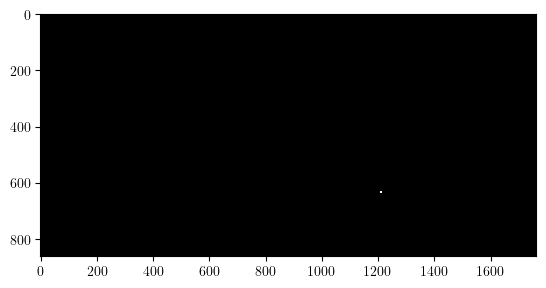

In [14]:
# plt imshow data/nyc_shade.tiff 
# open the raster and read it into a numpy array
with rasterio.open("../data/nyc_shade.tiff") as src:
    shade = src.read(1)
    shade = np.ma.masked_where(shade == 0, shade)

# plot the masked_array 
plt.imshow(shade, cmap='gray')

### Satellite Availability 

In [15]:
gso_satellite = pd.read_csv("../data/bdc_36_GSOSatellite_fixed_broadband_D23_06aug2024.csv", engine='pyarrow')

gso_satellite['block_geoid'] = gso_satellite['block_geoid'].astype(str)

In [16]:
# merge gso_satellite with cbs_nyc 
gso_satellite = cbs_nyc.merge(gso_satellite, right_on='block_geoid', left_on='GEOID', how='left')
gso_satellite = gpd.GeoDataFrame(gso_satellite, crs=PROJ)
logger.info(f"GSOSatellite data merged with Census Blocks. \n{gso_satellite.info()}")

2024-12-10 00:25:57 - robotability-score - INFO - GSOSatellite data merged with Census Blocks. 
None


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2470523 entries, 0 to 2470522
Data columns (total 18 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   CB2020                         object  
 1   BoroName                       object  
 2   GEOID                          object  
 3   Shape_Leng                     float64 
 4   Shape_Area                     float64 
 5   geometry                       geometry
 6   frn                            float64 
 7   provider_id                    float64 
 8   brand_name                     object  
 9   location_id                    float64 
 10  technology                     float64 
 11  max_advertised_download_speed  float64 
 12  max_advertised_upload_speed    float64 
 13  low_latency                    float64 
 14  business_residential_code      object  
 15  state_usps                     object  
 16  block_geoid                    object  
 17  h3_res8_id         

In [17]:
ngso_satellite = pd.read_csv("../data/bdc_36_NGSOSatellite_fixed_broadband_D23_06aug2024.csv", engine='pyarrow')
ngso_satellite['block_geoid'] = ngso_satellite['block_geoid'].astype(str)

# merge ngso_satellite with cbs_nyc
ngso_satellite = cbs_nyc.merge(ngso_satellite, right_on='block_geoid', left_on='GEOID', how='left')
ngso_satellite = gpd.GeoDataFrame(ngso_satellite, crs=PROJ)
logger.info(f"NSGOSatellite data merged with Census Blocks. \n{ngso_satellite.info()}")

2024-12-10 00:26:02 - robotability-score - INFO - NSGOSatellite data merged with Census Blocks. 
None


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 826917 entries, 0 to 826916
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   CB2020                         826917 non-null  object  
 1   BoroName                       826917 non-null  object  
 2   GEOID                          826917 non-null  object  
 3   Shape_Leng                     826917 non-null  float64 
 4   Shape_Area                     826917 non-null  float64 
 5   geometry                       826917 non-null  geometry
 6   frn                            821993 non-null  float64 
 7   provider_id                    821993 non-null  float64 
 8   brand_name                     821993 non-null  object  
 9   location_id                    821993 non-null  float64 
 10  technology                     821993 non-null  float64 
 11  max_advertised_download_speed  821993 non-null  float64 
 12  max_adve

### 4G LTE 


In [18]:
fourg_lte = gpd.read_file("../data/4g_ny/bdc_36_4GLTE_mobile_broadband_h3_D23_06aug2024.shp").to_crs(PROJ)

In [19]:
# prepnd '4g' to all columns except geometry
fourg_lte.columns = ['4g_' + col if col != 'geometry' else col for col in fourg_lte.columns]

In [20]:
# sjoin with sidewalks_nyc 
sidewalk_nyc = gpd.sjoin(fourg_lte, sidewalk_nyc, how='right', predicate='intersects').drop(columns=['index_left'])

In [21]:
fiveg_nr = gpd.read_file("../data/5g_ny/bdc_36_5GNR_mobile_broadband_h3_D23_06aug2024.shp").to_crs(PROJ)
# prepnd '5g' to all columns except geometry
fiveg_nr.columns = ['5g_' + col if col != 'geometry' else col for col in fiveg_nr.columns]

In [22]:
# sjoin with sidewalks_nyc
sidewalk_nyc = gpd.sjoin(fiveg_nr, sidewalk_nyc, how='right', op='intersects').drop(columns=['index_left'])

/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


### Surveillance Cameras 

In [23]:
surveillance_cameras = pd.read_csv("../data/decode-surveillance-nyc-1.1.0/data/counts_per_intersections.csv") 
surveillance_cameras

,PanoramaId,n_cameras_median,attached_street_median,attached_building_median,attached_unknown_median,type_dome_median,type_bullet_median,type_unknown_median,n_cameras_agreement,attached_street_agreement,...,attached_unknown_agreement,type_dome_agreement,type_bullet_agreement,type_unknown_agreement,Lat,Long,geometry_pano,BoroName,URL,ImageDate
0,--48RnFczF55WcDFpy5y_Q,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,Unanimous,40.870564,-73.869327,POINT (-73.86932652339482 40.87056425110688),Bronx,https://www.google.com/maps/@?api=1&map_action...,2019-08
1,--T2iuvfxXJrzbgD7R3W-g,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,2 vs 1,Unanimous,Unanimous,Unanimous,40.669099,-73.762447,POINT (-73.76244689609075 40.6690985670363),Queens,https://www.google.com/maps/@?api=1&map_action...,2020-10
2,--VGAsqPgTXxgZFXuhuhbg,0,0,0,0,0,0,0,Unanimous,Unanimous,...,Unanimous,Unanimous,Unanimous,Unanimous,40.766790,-73.771211,POINT (-73.7712107859631 40.76679030231237),Queens,https://www.google.com/maps/@?api=1&map_action...,2020-11
3,--YJY0GGvay_3W_O5ObeNQ,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,Unanimous,40.554253,-74.201603,POINT (-74.20160298846051 40.55425348634071),Staten Island,https://www.google.com/maps/@?api=1&map_action...,2019-09
4,--fUkaf5nn1-bm4KiJ9pVA,1,0,1,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,Unanimous,40.611084,-74.162803,POINT (-74.16280280196275 40.61108412672856),Staten Island,https://www.google.com/maps/@?api=1&map_action...,2019-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,zzj23G_f-_hZa1LrXJ7tig,0,0,0,0,0,0,0,2 vs 1,2 vs 1,...,Unanimous,Unanimous,Unanimous,2 vs 1,40.889133,-73.821303,POINT (-73.82130317259254 40.88913324730224),Bronx,https://www.google.com/maps/@?api=1&map_action...,2019-11
43402,zzpZoM4JHrGNywYitkYT8w,1,0,0,0,0,0,0,2 vs 1,2 vs 1,...,Unanimous,2 vs 1,Unanimous,Unanimous,40.750994,-73.706451,POINT (-73.7064507165946 40.75099428476829),Queens,https://www.google.com/maps/@?api=1&map_action...,2019-07
43403,zztPjLBFQjwEISsA75a-zg,1,1,0,0,1,0,0,All disagree,All disagree,...,Unanimous,All disagree,2 vs 1,Unanimous,40.730852,-73.947876,POINT (-73.9478762022405 40.73085200510598),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-10
43404,zzv84J0v5tQobN5uCXO1xw,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,Unanimous,40.675203,-73.778650,POINT (-73.77864970575715 40.67520299190087),Queens,https://www.google.com/maps/@?api=1&map_action...,2018-07


In [24]:
surveillance_cameras = surveillance_cameras[['n_cameras_median', 'geometry_pano']]
# drop na geometries 
surveillance_cameras = surveillance_cameras.dropna(subset=['geometry_pano'])
surveillance_cameras = gpd.GeoDataFrame(surveillance_cameras, geometry=wkt.loads(surveillance_cameras['geometry_pano']), crs=WGS).to_crs(PROJ)


In [25]:
# draw a buffer around each camera, merge with sidewalk_nyc
surveillance_cameras['geometry'] = surveillance_cameras.buffer(50)
merged = gpd.sjoin(sidewalk_nyc, surveillance_cameras, how='left', predicate='intersects')

# count the number of cameras within each sidewalk segment
merged = merged.groupby('point_index')['n_cameras_median'].count().reset_index()

# merge with sidewalk_nyc
sidewalk_nyc = sidewalk_nyc.merge(merged, left_on='point_index', right_index=True, how='left', suffixes=('', '_cameras')).drop(columns=['point_index_cameras'])


In [26]:
sidewalk_nyc 

,5g_technology,5g_mindown,5g_minup,5g_environmnt,5g_h3_res9_id,4g_technology,4g_mindown,4g_minup,4g_environmnt,4g_h3_res9_id,width,geometry,point_index,ft_above_sea,n_cameras_median
0,500.0,35.0,3.0,1.0,892a106e287ffff,NaN,NaN,NaN,NaN,NaN,4.886091,POINT (915013.944 120812.785),0,10,0
1,500.0,35.0,3.0,1.0,892a106e287ffff,NaN,NaN,NaN,NaN,NaN,4.886091,POINT (915025.799 120776.127),1,10,0
2,500.0,35.0,3.0,1.0,892a106e287ffff,NaN,NaN,NaN,NaN,NaN,4.886091,POINT (915037.653 120739.468),2,9,0
3,500.0,35.0,3.0,1.0,892a106e287ffff,NaN,NaN,NaN,NaN,NaN,4.886091,POINT (915049.507 120702.810),3,9,0
4,500.0,35.0,3.0,1.0,892a106e287ffff,NaN,NaN,NaN,NaN,NaN,4.886091,POINT (915061.361 120666.152),4,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874603,500.0,35.0,3.0,1.0,892a10054bbffff,400.0,5.0,1.0,1.0,892a10054bbffff,13.357439,POINT (1060640.780 218459.375),1874603,183,0
1874604,500.0,35.0,3.0,1.0,892a10054bbffff,400.0,5.0,1.0,1.0,892a10054bbffff,13.357439,POINT (1060670.385 218499.553),1874604,183,0
1874605,500.0,35.0,3.0,1.0,892a10054bbffff,400.0,5.0,1.0,1.0,892a10054bbffff,13.357439,POINT (1060699.989 218539.731),1874605,183,0
1874606,500.0,35.0,3.0,1.0,892a10054bbffff,400.0,5.0,1.0,1.0,892a10054bbffff,13.357439,POINT (1060729.594 218579.909),1874606,183,0


### Street Furniture 

In [28]:
street_furniture_nyc = pd.read_csv("../data/processed/street_furniture_density.csv", engine='pyarrow')

logger.success("Street furniture density data loaded.")

2024-12-10 00:36:17 - robotability-score - SUCCESS - Street furniture density data loaded.


In [29]:
sidewalk_nyc = sidewalk_nyc.merge(street_furniture_nyc, on='point_index', how='left', suffixes=('','_street_furniture'))
print(sidewalk_nyc.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1874608 entries, 0 to 1874607
Data columns (total 32 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   5g_technology                  float64 
 1   5g_mindown                     float64 
 2   5g_minup                       float64 
 3   5g_environmnt                  float64 
 4   5g_h3_res9_id                  object  
 5   4g_technology                  float64 
 6   4g_mindown                     float64 
 7   4g_minup                       float64 
 8   4g_environmnt                  float64 
 9   4g_h3_res9_id                  object  
 10  width                          float64 
 11  geometry                       geometry
 12  point_index                    int64   
 13  ft_above_sea                   uint16  
 14  n_cameras_median               int64   
 15  Unnamed: 0                     int64   
 16  width_street_furniture         float64 
 17  geometry_street_fur

### NYC Zoning (ZOLA)

In [30]:
zoning_nyc = gpd.read_file("../data/nyc_zoning/nyzd.shp")

logger.success("ZOLA data loaded.")

2024-12-10 00:36:19 - robotability-score - SUCCESS - ZOLA data loaded.


In [31]:
# get the zoning of each point in sidewalk_nyc
sidewalk_nyc = gpd.sjoin(sidewalk_nyc, zoning_nyc, how='left', predicate='intersects').drop(columns=['index_right'])
print(sidewalk_nyc.info())


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1874608 entries, 0 to 1874607
Data columns (total 35 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   5g_technology                  float64 
 1   5g_mindown                     float64 
 2   5g_minup                       float64 
 3   5g_environmnt                  float64 
 4   5g_h3_res9_id                  object  
 5   4g_technology                  float64 
 6   4g_mindown                     float64 
 7   4g_minup                       float64 
 8   4g_environmnt                  float64 
 9   4g_h3_res9_id                  object  
 10  width                          float64 
 11  geometry                       geometry
 12  point_index                    int64   
 13  ft_above_sea                   uint16  
 14  n_cameras_median               int64   
 15  Unnamed: 0                     int64   
 16  width_street_furniture         float64 
 17  geometry_street_furnitur

### CitiBike Stations 
We simulate charging stations in the environment with existing CitiBike charging stations. It is also possible to simulate this via random sampling of the NYC road network, but we think citibike stations might be a more accurate distribution to pull from , as they are influenced by population density and zoning patterns. 

In [32]:
citibike_stations_nyc = pd.read_json("../data/citibike/station_information.json")
citibike_stations_nyc = pd.json_normalize(citibike_stations_nyc['data']).T 
citibike_stations_nyc = pd.json_normalize(citibike_stations_nyc[0])
citibike_stations_nyc = gpd.GeoDataFrame(citibike_stations_nyc, geometry=gpd.points_from_xy(citibike_stations_nyc['lon'], citibike_stations_nyc['lat']), crs=WGS).to_crs(PROJ)

# get nearest station to each point in sidewalk nyc 
nearest_station_to_pt = gpd.sjoin_nearest(sidewalk_nyc, citibike_stations_nyc, how='left', distance_col='distance_to_nearest_station').drop(columns=['index_right'])

# merge 'distance_to_nearest_station' with sidewalk_nyc
sidewalk_nyc = sidewalk_nyc.merge(nearest_station_to_pt[['point_index','distance_to_nearest_station']], on='point_index', how='left')


logger.success("Citibike stations data loaded.")

2024-12-10 00:36:57 - robotability-score - SUCCESS - Citibike stations data loaded.


### Street Lighting 

### Curb Ramps 

In [33]:
curb_ramps_nyc = pd.read_csv("../data/pedestrian_curb_ramp_nyc.csv")
# prepend 'CURBRAMP' to each column name
curb_ramps_nyc.columns = [f'CURBRAMP_{col}' for col in curb_ramps_nyc.columns]
curb_ramps_nyc = gpd.GeoDataFrame(curb_ramps_nyc, geometry=wkt.loads(curb_ramps_nyc['CURBRAMP_the_geom']), crs=WGS).to_crs(PROJ)

# only keep curb ramps that are 'Good Condition' in the CURBRAMP_DWS_CONDITIONS col
curb_ramps_nyc = curb_ramps_nyc[curb_ramps_nyc['CURBRAMP_DWS_CONDITIONS'] == 'Good Condition']

In [34]:
# buffer the curb ramps and merge with sidewalk_nyc 
curb_ramps_nyc['geometry'] = curb_ramps_nyc['geometry'].buffer(50)
merged = gpd.sjoin(sidewalk_nyc, curb_ramps_nyc, how='left', predicate='intersects').drop(columns=['index_right'])
merged = merged.groupby('point_index')['CURBRAMP_RampID'].agg('count').to_frame().rename(columns={'CURBRAMP_RampID':'CURBRAMP_count'})

# groupby CURBRAMP_RampID and count the number of curb ramps in each group
sidewalk_nyc = sidewalk_nyc.merge(merged, left_on='point_index', right_index=True, how='left')
print(sidewalk_nyc.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1874608 entries, 0 to 1874607
Data columns (total 37 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   5g_technology                  float64 
 1   5g_mindown                     float64 
 2   5g_minup                       float64 
 3   5g_environmnt                  float64 
 4   5g_h3_res9_id                  object  
 5   4g_technology                  float64 
 6   4g_mindown                     float64 
 7   4g_minup                       float64 
 8   4g_environmnt                  float64 
 9   4g_h3_res9_id                  object  
 10  width                          float64 
 11  geometry                       geometry
 12  point_index                    int64   
 13  ft_above_sea                   uint16  
 14  n_cameras_median               int64   
 15  Unnamed: 0                     int64   
 16  width_street_furniture         float64 
 17  geometry_street_fur

### Raised Crosswalks 

In [35]:
raised_crosswalks_nyc = pd.read_csv("../data/raised_crosswalks_nyc.csv")
raised_crosswalks_nyc.columns = [f'RAISEDCROSSWALK_{col}' for col in raised_crosswalks_nyc.columns]

In [36]:
raised_crosswalks_nyc = gpd.GeoDataFrame(raised_crosswalks_nyc, geometry=wkt.loads(raised_crosswalks_nyc['RAISEDCROSSWALK_WKT Geometry']), crs=PROJ)
raised_crosswalks_nyc['RAISEDCROSSWALK_index'] = raised_crosswalks_nyc.index
# prepend 'RAISEDCROSSWALK' to each column name
# buffer the raised crosswalks and merge with sidewalk_nyc
raised_crosswalks_nyc['geometry'] = raised_crosswalks_nyc['geometry'].buffer(50)


merged = gpd.sjoin(sidewalk_nyc, raised_crosswalks_nyc, how='left', predicate='intersects').drop(columns=['index_right'])
merged = merged.groupby('point_index')['RAISEDCROSSWALK_index'].agg('count').to_frame().rename(columns={'RAISEDCROSSWALK_index':'RAISEDCROSSWALK_count'})

# groupby RAISEDCROSSWALK_index and count the number of raised crosswalks in each group
sidewalk_nyc = sidewalk_nyc.merge(merged, left_on='point_index', right_index=True, how='left')

print(sidewalk_nyc.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1874608 entries, 0 to 1874607
Data columns (total 38 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   5g_technology                  float64 
 1   5g_mindown                     float64 
 2   5g_minup                       float64 
 3   5g_environmnt                  float64 
 4   5g_h3_res9_id                  object  
 5   4g_technology                  float64 
 6   4g_mindown                     float64 
 7   4g_minup                       float64 
 8   4g_environmnt                  float64 
 9   4g_h3_res9_id                  object  
 10  width                          float64 
 11  geometry                       geometry
 12  point_index                    int64   
 13  ft_above_sea                   uint16  
 14  n_cameras_median               int64   
 15  Unnamed: 0                     int64   
 16  width_street_furniture         float64 
 17  geometry_street_fur

### Sidewalk Scorecard 


In [37]:
sidewalk_scorecard_nyc = pd.read_csv("../data/Scorecard_Ratings_20240814.csv") 
sidewalk_scorecard_nyc
sidewalk_scorecard_nyc.columns = [f'SCORECARD_{col}' for col in sidewalk_scorecard_nyc.columns]
# only keep 2023/09 
sidewalk_scorecard_nyc = sidewalk_scorecard_nyc[sidewalk_scorecard_nyc['SCORECARD_Month'] == '2023 / 09']

In [38]:
sidewalk_scorecard_nyc['cd_code'] = sidewalk_scorecard_nyc['SCORECARD_Community Board']
boro_mapping = { 
    'Manhattan': 1,
    'Bronx': 2,
    'Brooklyn': 3,
    'Queens': 4,
    'Staten Island': 5
}

sidewalk_scorecard_nyc['boro_code'] = sidewalk_scorecard_nyc['SCORECARD_Borough'].map(boro_mapping)

sidewalk_scorecard_nyc['cd_code'] = sidewalk_scorecard_nyc['cd_code'].astype(str)
sidewalk_scorecard_nyc['boro_code'] = sidewalk_scorecard_nyc['boro_code'].astype(str)

# prepend boro_code to cd_code, and padd cd_code so its always 2 digits 
sidewalk_scorecard_nyc['cd_code'] = sidewalk_scorecard_nyc['boro_code'] + sidewalk_scorecard_nyc['cd_code'].str.zfill(2)
sidewalk_scorecard_nyc.drop(columns=['SCORECARD_Month', 'SCORECARD_Borough', 'SCORECARD_Community Board', 'SCORECARD_District', 'SCORECARD_Cleaning Section', 'boro_code'], inplace=True)
# cast cd_code to int 
sidewalk_scorecard_nyc['cd_code'] = sidewalk_scorecard_nyc['cd_code'].astype(int)

# aggregate together rows with the same cd_code and mean 
sidewalk_scorecard_nyc = sidewalk_scorecard_nyc.groupby('cd_code').mean().reset_index()



cds_nyc = cds_nyc.merge(sidewalk_scorecard_nyc, left_on='boro_cd', right_on='cd_code', how='left')

cds_nyc['sidewalk_quality'] = cds_nyc['SCORECARD_Acceptable Streets % - Previous Month']

# drop all 'SCORECARD_' prefixed columns 
TO_DROP = [col for col in cds_nyc.columns if 'SCORECARD_' in col]
cds_nyc = cds_nyc.drop(columns=TO_DROP)

In [39]:
# now, spatial join of cds_nyc with sidewalk_nyc
sidewalk_nyc = gpd.sjoin(sidewalk_nyc, cds_nyc, how='left', predicate='intersects').drop(columns=['index_right'])
print(sidewalk_nyc.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1874608 entries, 0 to 1874607
Data columns (total 43 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   5g_technology                  float64 
 1   5g_mindown                     float64 
 2   5g_minup                       float64 
 3   5g_environmnt                  float64 
 4   5g_h3_res9_id                  object  
 5   4g_technology                  float64 
 6   4g_mindown                     float64 
 7   4g_minup                       float64 
 8   4g_environmnt                  float64 
 9   4g_h3_res9_id                  object  
 10  width                          float64 
 11  geometry                       geometry
 12  point_index                    int64   
 13  ft_above_sea                   uint16  
 14  n_cameras_median               int64   
 15  Unnamed: 0                     int64   
 16  width_street_furniture         float64 
 17  geometry_street_furnitur

### Points of Interest 

In [40]:
pois_nyc = pd.read_csv("../data/pois_nyc.csv") 
# prepend 'POI' to each column name
pois_nyc.columns = [f'POI_{col}' for col in pois_nyc.columns]
pois_nyc = gpd.GeoDataFrame(pois_nyc, geometry=wkt.loads(pois_nyc['POI_the_geom']), crs=WGS).to_crs(PROJ)

In [41]:
# buffer the pois and merge with sidewalk_nyc
pois_nyc['geometry'] = pois_nyc['geometry'].buffer(50)
sidewalk_nyc = gpd.sjoin(sidewalk_nyc, pois_nyc, how='left', predicate='intersects').drop(columns=['index_right'])

### Traffic Density 

In [42]:
traffic_nyc = pd.read_csv("../data/avg_traffic_by_sidewalk_august.csv", engine='pyarrow')

In [43]:
traffic_nyc = traffic_nyc[['point_index', '0','1','2']]
# columns = 'pedestrian', 'bike', 'car', 
traffic_nyc.columns = ['point_index', 'TRAFFIC_Pedestrian', 'TRAFFIC_Bike', 'TRAFFIC_Car']

In [44]:
# merge 
sidewalk_nyc = sidewalk_nyc.merge(traffic_nyc, on='point_index', how='left')

In [45]:
sidewalk_nyc

,5g_technology,5g_mindown,5g_minup,5g_environmnt,5g_h3_res9_id,4g_technology,4g_mindown,4g_minup,4g_environmnt,4g_h3_res9_id,...,POI_CREATED,POI_MODIFIED,POI_FACILITY_T,POI_SOURCE,POI_B7SC,POI_PRI_ADD,POI_NAME,TRAFFIC_Pedestrian,TRAFFIC_Bike,TRAFFIC_Car
0,500.0,35.0,3.0,1.0,892a106e287ffff,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,500.0,35.0,3.0,1.0,892a106e287ffff,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,500.0,35.0,3.0,1.0,892a106e287ffff,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,500.0,35.0,3.0,1.0,892a106e287ffff,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,500.0,35.0,3.0,1.0,892a106e287ffff,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876409,500.0,35.0,3.0,1.0,892a10054bbffff,400.0,5.0,1.0,1.0,892a10054bbffff,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142857,0.0,8.857143
1876410,500.0,35.0,3.0,1.0,892a10054bbffff,400.0,5.0,1.0,1.0,892a10054bbffff,...,05/14/2009 12:00:00 AM,11/27/2017 12:00:00 AM,5.0,EMS,NaN,190942.0,LITTLE NECK CARE CENTER,0.250000,0.0,6.500000
1876411,500.0,35.0,3.0,1.0,892a10054bbffff,400.0,5.0,1.0,1.0,892a10054bbffff,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714,0.0,8.142857
1876412,500.0,35.0,3.0,1.0,892a10054bbffff,400.0,5.0,1.0,1.0,892a10054bbffff,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.800000,0.0,7.600000


### Shade 

In [46]:
# load tree census data 
tree_census_nyc = pd.read_csv("../data/tree_census_nyc.csv", engine='pyarrow')



In [47]:
tree_census_nyc.columns 

Index(['created_at', 'tree_id', 'block_id', 'the_geom', 'tree_dbh',
       'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin', 'spc_common',
       'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trnk_wire', 'trnk_light', 'trnk_other',
       'brnch_ligh', 'brnch_shoe', 'brnch_othe', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'cncldist', 'st_assem',
       'st_senate', 'nta', 'nta_name', 'boro_ct', 'state', 'Latitude',
       'longitude', 'x_sp', 'y_sp'],
      dtype='object')

### Speed Limits 


In [48]:
speed_limits_nyc = pd.read_csv("../data/dot_VZV_Speed_Limits_20240814.csv")
speed_limits_nyc = gpd.GeoDataFrame(speed_limits_nyc, geometry=wkt.loads(speed_limits_nyc['the_geom']), crs=WGS).to_crs(PROJ)

In [49]:
merged = gpd.sjoin_nearest(sidewalk_nyc, speed_limits_nyc, how='left', distance_col='distance_to_nearest_speed_limit', max_distance=50).drop(columns=['index_right'])

avg_speed_limit = merged.groupby('point_index')['postvz_sl'].mean().to_frame().rename(columns={'postvz_sl':'avg_speed_limit'})

sidewalk_nyc = sidewalk_nyc.merge(avg_speed_limit, left_on='point_index', right_index=True, how='left')

sidewalk_nyc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1876414 entries, 0 to 1876413
Data columns (total 63 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   5g_technology                  float64 
 1   5g_mindown                     float64 
 2   5g_minup                       float64 
 3   5g_environmnt                  float64 
 4   5g_h3_res9_id                  object  
 5   4g_technology                  float64 
 6   4g_mindown                     float64 
 7   4g_minup                       float64 
 8   4g_environmnt                  float64 
 9   4g_h3_res9_id                  object  
 10  width                          float64 
 11  geometry                       geometry
 12  point_index                    int64   
 13  ft_above_sea                   uint16  
 14  n_cameras_median               int64   
 15  Unnamed: 0                     int64   
 16  width_street_furniture         float64 
 17  geometry_street_fur

### Traffic Management Systems

### Neighborhood Slow Zones 

In [50]:
neighborhood_slow_zones_nyc = pd.read_csv("../data/dot_VZV_Neighborhood_Slow_Zones_20240814.csv")
# prepend 'NEIGHBORHOODSLOWZONE' to each column name
neighborhood_slow_zones_nyc.columns = [f'NEIGHBORHOODSLOWZONE_{col}' for col in neighborhood_slow_zones_nyc.columns]
neighborhood_slow_zones_nyc = gpd.GeoDataFrame(neighborhood_slow_zones_nyc, geometry=wkt.loads(neighborhood_slow_zones_nyc['NEIGHBORHOODSLOWZONE_the_geom']), crs=WGS).to_crs(PROJ)

In [51]:
# sjoin with sidewalk_nyc
merged = gpd.sjoin(sidewalk_nyc, neighborhood_slow_zones_nyc, how='left', predicate='intersects').drop(columns=['index_right'])

# if the point is in a slow zone, set 'in_slow_zone' to 1, else 0
merged['in_slow_zone'] = merged['NEIGHBORHOODSLOWZONE_Name'].notnull().astype(int)

# put back into sidewalk_nyc 
sidewalk_nyc['in_slow_zone'] = merged['in_slow_zone']


### Turn Traffic Calming 

In [52]:
turn_traffic_calming_nyc = pd.read_csv("../data/dot_VZV_Turn_Traffic_Calming_20240814.csv")
turn_traffic_calming_nyc = gpd.GeoDataFrame(turn_traffic_calming_nyc, geometry=wkt.loads(turn_traffic_calming_nyc['the_geom']), crs=WGS).to_crs(PROJ)
turn_traffic_calming_nyc['ttc_index'] = turn_traffic_calming_nyc.index

In [53]:
# buffer the traffic calming features and merge with sidewalk_nyc
turn_traffic_calming_nyc['geometry'] = turn_traffic_calming_nyc['geometry'].buffer(50)

merged = gpd.sjoin(sidewalk_nyc, turn_traffic_calming_nyc, how='left', predicate='intersects').drop(columns=['index_right'])
merged = merged.groupby('point_index')['ttc_index'].agg('count').to_frame().rename(columns={'ttc_index':'turn_traffic_calming_count'})

sidewalk_nyc['turn_traffic_calming_count'] = merged


### SIP Intersections 

In [54]:
sip_intersections_nyc = pd.read_csv("../data/dot_VZV_SIP_Intersections_20240814.csv")
sip_intersections_nyc = gpd.GeoDataFrame(sip_intersections_nyc, geometry=wkt.loads(sip_intersections_nyc['the_geom']), crs=WGS).to_crs(PROJ)
sip_intersections_nyc['sipi_index'] = sip_intersections_nyc.index


In [55]:
# buffer the sip intersections and merge with sidewalk_nyc
sip_intersections_nyc['geometry'] = sip_intersections_nyc['geometry'].buffer(50)

merged = gpd.sjoin(sidewalk_nyc, sip_intersections_nyc, how='left', predicate='intersects').drop(columns=['index_right'])
merged = merged.groupby('point_index')['sipi_index'].agg('count').to_frame().rename(columns={'sipi_index':'sip_intersections_count'})

sidewalk_nyc['sip_intersections_count'] = merged

### SIP Corridors 

In [56]:
sip_corridors_nyc = pd.read_csv("../data/dot_VZV_SIP_Corridors_20240814.csv")
sip_corridors_nyc = gpd.GeoDataFrame(sip_corridors_nyc, geometry=wkt.loads(sip_corridors_nyc['the_geom']), crs=WGS).to_crs(PROJ)
sip_corridors_nyc['sipc_index'] = sip_corridors_nyc.index

In [57]:
# buffer the sip corridors and merge with sidewalk_nyc
sip_corridors_nyc['geometry'] = sip_corridors_nyc['geometry'].buffer(50)

merged = gpd.sjoin(sidewalk_nyc, sip_corridors_nyc, how='left', predicate='intersects').drop(columns=['index_right'])
merged = merged.groupby('point_index')['sipc_index'].agg('count').to_frame().rename(columns={'sipc_index':'sip_corridors_count'})

sidewalk_nyc['sip_corridors_count'] = merged

### Barnes Dance Intersections 

In [58]:
barnes_intersections_nyc = pd.read_csv("../data/Exclusive_Pedestrian_Signal__Barnes_Dance__Locations_20240822.csv")
barnes_intersections_nyc = gpd.GeoDataFrame(barnes_intersections_nyc, geometry=wkt.loads(barnes_intersections_nyc['the_geom']), crs=WGS).to_crs(PROJ)
barnes_intersections_nyc['barnes_index'] = barnes_intersections_nyc.index

In [59]:
# buffer the barnes dance intersections and merge with sidewalk_nyc
barnes_intersections_nyc['geometry'] = barnes_intersections_nyc['geometry'].buffer(50)

merged = gpd.sjoin(sidewalk_nyc, barnes_intersections_nyc, how='left', predicate='intersects').drop(columns=['index_right'])
merged = merged.groupby('point_index')['barnes_index'].agg('count').to_frame().rename(columns={'barnes_index':'barnes_intersections_count'})

sidewalk_nyc['barnes_intersections_count'] = merged

### Leading Pedestrian Intervals 

In [60]:
leading_ped_intervals_nyc = pd.read_csv("../data/dot_VZV_Leading_Pedestrian_Intervals_20240130.csv")
leading_ped_intervals_nyc = gpd.GeoDataFrame(leading_ped_intervals_nyc, geometry=wkt.loads(leading_ped_intervals_nyc['the_geom']), crs=WGS).to_crs(PROJ)
leading_ped_intervals_nyc['lpi_index'] = leading_ped_intervals_nyc.index

In [61]:
# buffer the leading pedestrian intervals and merge with sidewalk_nyc
leading_ped_intervals_nyc['geometry'] = leading_ped_intervals_nyc['geometry'].buffer(50)

merged = gpd.sjoin(sidewalk_nyc, leading_ped_intervals_nyc, how='left', predicate='intersects').drop(columns=['index_right'])
merged = merged.groupby('point_index')['lpi_index'].agg('count').to_frame().rename(columns={'lpi_index':'leading_ped_intervals_count'})

sidewalk_nyc['leading_ped_intervals_count'] = merged

### Bike Routes 

In [62]:
bike_routes_nyc = pd.read_csv("../data/New_York_City_Bike_Routes_20240818.csv")
bike_routes_nyc = gpd.GeoDataFrame(bike_routes_nyc, geometry=wkt.loads(bike_routes_nyc['the_geom']), crs=WGS).to_crs(PROJ)
bike_routes_nyc = bike_routes_nyc[bike_routes_nyc['status'] == 'Current']
bike_routes_nyc = bike_routes_nyc[['bikeid', 'geometry', 'facilitycl']]
bike_routes_nyc.columns = ['bikeid', 'geometry', 'highest_bike_lane_facility_class']

bike_routes_nyc['highest_bike_lane_facility_class'].value_counts()

fc_to_int = { 
    'L': 0.5, 
    'I': 1,
    'II': 2,
    'III': 3,
}

bike_routes_nyc['highest_bike_lane_facility_class'] = bike_routes_nyc['highest_bike_lane_facility_class'].map(fc_to_int)
bike_routes_nyc['highest_bike_lane_facility_class'].describe()

count    22983.000000
mean         1.801049
std          0.749003
min          0.500000
25%          1.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: highest_bike_lane_facility_class, dtype: float64

In [63]:
# sjoin with sidewalk_nyc
merged = gpd.sjoin_nearest(sidewalk_nyc, bike_routes_nyc, how='left', distance_col='distance_to_nearest_bike_route', max_distance=50).drop(columns=['index_right'])

# get the highest bike lane facility class for each point
highest_bike_lane_facility_class = merged.groupby('point_index')['highest_bike_lane_facility_class'].mean().to_frame().rename(columns={'highest_bike_lane_facility_class':'avg_highest_bike_lane_facility_class'}).fillna(0)

sidewalk_nyc['highest_bike_lane_facility_class'] = highest_bike_lane_facility_class




### Traffic Collisions 

In [64]:
traffic_collisions_nyc = pd.read_csv("../data/Motor_Vehicle_Collisions_-_Crashes_20240822.csv")
# TIME FILTER 

traffic_collisions_nyc['num_peds_involved'] = traffic_collisions_nyc['NUMBER OF PEDESTRIANS INJURED'] + traffic_collisions_nyc['NUMBER OF PEDESTRIANS KILLED']

In [65]:
traffic_collisions_nyc.dropna(subset=['LATITUDE','LONGITUDE'], inplace=True)
traffic_collisions_nyc = gpd.GeoDataFrame(traffic_collisions_nyc, geometry=gpd.points_from_xy(traffic_collisions_nyc['LONGITUDE'], traffic_collisions_nyc['LATITUDE']), crs=WGS).to_crs(PROJ)

# buffer the traffic collisions and merge with sidewalk_nyc
traffic_collisions_nyc['geometry'] = traffic_collisions_nyc['geometry'].buffer(50)

merged = gpd.sjoin(sidewalk_nyc, traffic_collisions_nyc, how='left', predicate='intersects').drop(columns=['index_right'])

merged = merged.groupby('point_index')[['num_peds_involved']].sum().reset_index()



In [66]:
sidewalk_nyc['num_peds_involved_in_collision'] = merged['num_peds_involved']
sidewalk_nyc['num_peds_involved_in_collision'].describe()

count    1.874608e+06
mean     3.443066e-02
std      2.352207e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: num_peds_involved_in_collision, dtype: float64

## Features that will not be modeled with empirical data 

### Weather Conditions 
We will assign weights to different types of weather. However, weather conditions may not be considered in use-cases where only the static built-environment is considered. 

### Existence of Detailed Digital Maps 

In the case of New York City, the entire city is covered by a DCM. As such, there is no need to bring this indicator in empirically, as the variance across the city is 0. 

## Features that cannot be modeled with empirical data 

### Sidewalk material 
There is no known dataset of sidewalk materials at the per-sidewalk level in NYC. Further, we deem that there is low variance; ie. the majority of sidewalks are all concrete. 

### Street lighting 
There is no known dataset of street lighting / lamp-posts in NYC. While a subset can be derived via the locations of relevant 311 complaints, we are unaware if this subset is representative of the overall distribution. 

## Features that are inferred via proxy datasets / other empirical data 


### Pedestrian flow 

### Sidewalk surface roughness 
We proxy this indicator via the sidewalk scorecard ratings dataset, which reports results at a granularity of the community district level.

### Shade 
We infer shade levels via the TreeFolio NYC dataset, which to-date only considers shade cast by street trees. There are other sources of shade in the city, namely tall buildings. 

## In-house indicators 

### Pedestrian density 
We compute the typical pedestrian densities at the per-sidewawlk level via YOLO (pretrained on COCO) inference on a large dataset of crowdsourced dashcam images. There are limitations. Namely, not every street segment in the city is covered: about 1/3 of our densely-sampled points along the sidewalk network lack data. Further, it is nontrivial & noisy to isolate which side of the street a pedestrian is walking on, and so there is noise in the map matching process. 

### Bike density
We compute bicycle densities using the same process as pedestrian density; and so, the same limitations carry over.  

### Vehicle density 
We compute vehicle densities using the same process as pedestrian density; and so, the same limitations carry over. 

In [67]:
sidewalk_nyc.to_csv("../data/processed/score_dataset.csv")